# Recommender System

For this project, we will be build 2 Recommender System Models to recommend restaurants based on our dataset

The first model is a content-based recommendation system that recommends 20 restaurants based on a selection, intended to be recommended based on past data where applicable. Using a cosine similarity matrix

The secon model is a location-based recommendation system that utilizes longitude and latitude to recommend the top 10 restaurants closest based on location, ideally taking into account overall review ratings.


Source:
- "Build Your Own Clustering Based Recommendation Engine in 15 minutes" by Ashish Rana [*(Medium)*](https://towardsdatascience.com/build-your-own-clustering-based-recommendation-engine-in-15-minutes-bdddd591d394)
- "Review of Clustering-Based Recommender Systems" by [*Irina Beregovskaya, Mikhail Koroteev*](https://arxiv.org/abs/2109.12839)
- "Location-Based Recommendations" by Abdishakur[*Medium*(https://towardsdatascience.com/location-based-recommendations-bb70af7b1538])

In [67]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score

import os
import ast
import pickle

In [22]:
data = pd.read_csv('../Data/GTA_sentimentt.csv')

In [23]:
data.head(2)

,business_id,name,city,state,latitude,longitude,stars,attributes,categories,user_id,review_stars,text,review_counts,year,text_word_count,pos_neg,text_clean
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,43.605499,-79.652289,2.5,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...",2K62MJ4CJ19L8Tp5pRfjfQ,3.0,My girlfriend and I went for dinner at Emerald...,134,2017,242,0,girlfriend went dinner emerald chinese thursda...
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,43.605499,-79.652289,2.5,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...",SuOLY03LW5ZcnynKhbTydA,3.0,"***No automatic doors, not baby friendly!*** I...",134,2016,43,0,automatic door baby friendly frequent chinese ...


In [24]:
data.shape


(328594, 17)

In [25]:
cbf = data.groupby('name')['text_clean'].sum()
cbf = cbf.to_frame(name = 'rev').reset_index()
cbf

,name,rev
0,&Company Resto Bar,dont know happened place went girlfriend satur...
1,'ONO Poké Bar,45 craving poke bowl longest time im super hap...
2,00 Gelato,one best gelatos toronto chocolate raspberry f...
3,0109 Dessert & Chocolate,delicious place loved environment cleanliness ...
4,1 Plus 2 Pizza & Wings,worst customer service everhate place u dont k...
...,...,...
5484,pico de gallo,office delivery order pico de gallo thoroughly...
5485,süüp health bar,came across hidden gem chance coupon tried unl...
5486,teashop 168,man wish still sold frozen yougurt yougen fruz...
5487,yuan yuan Chinese Restaurant,kinda new northern chinese cuisine dining area...


In [ ]:
We are now left with from 7,283 unique restaurants from our initial cleaned GTA file

In [26]:
cbf.to_csv('../Data/GTA_cbf_final.csv', index = False)

In [30]:
cbf = pd.read_csv('../Data/GTA_cbf_final 2.csv')

In [32]:
cbf.head()

,name,rev
0,&Company Resto Bar,dont know happened place went girlfriend satur...
1,'ONO Poké Bar,45 craving poke bowl longest time im super hap...
2,00 Gelato,one best gelatos toronto chocolate raspberry f...
3,0109 Dessert & Chocolate,delicious place loved environment cleanliness ...
4,1 Plus 2 Pizza & Wings,worst customer service everhate place u dont k...


In [33]:
cbf['rev'] = cbf['rev'].map(lambda x: x.replace(", ","', '"))
cbf['rev'] = cbf['rev'].map(lambda x: str("'") + x + str("'"))
f = lambda x: x["rev"].split(", ")
cbf['rev'] = cbf.apply(f, axis=1)
cbf['rev'] = cbf['rev'].map(lambda x: set(x))
cbf.set_index('name', inplace = True)
cbf.head()

,rev
name,
&Company Resto Bar,{'dont know happened place went girlfriend sat...
'ONO Poké Bar,{'45 craving poke bowl longest time im super h...
00 Gelato,{'one best gelatos toronto chocolate raspberry...
0109 Dessert & Chocolate,{'delicious place loved environment cleanlines...
1 Plus 2 Pizza & Wings,{'worst customer service everhate place u dont...


In [35]:
cbf.to_csv('../Data/GTATop5_final.csv', index = False)

In [39]:
cbf['bag_of_words'] = ''
columns = cbf.columns
for index, row in cbf.iterrows():
    words = ''
    for col in columns:
            words = words + ' '.join(row[col])+ ' '
    row['bag_of_words'] = words
    
cbf.drop(columns = [col for col in toronto_final.columns if col!= 'bag_of_words'], inplace = True)
cbf['bag_of_words'] = cbf['bag_of_words'].map(lambda x: x.replace("'", ""))
cbf.head()

,rev,bag_of_words
name,,
&Company Resto Bar,{'dont know happened place went girlfriend sat...,dont know happened place went girlfriend satur...
'ONO Poké Bar,{'45 craving poke bowl longest time im super h...,45 craving poke bowl longest time im super hap...
00 Gelato,{'one best gelatos toronto chocolate raspberry...,one best gelatos toronto chocolate raspberry f...
0109 Dessert & Chocolate,{'delicious place loved environment cleanlines...,delicious place loved environment cleanliness ...
1 Plus 2 Pizza & Wings,{'worst customer service everhate place u dont...,worst customer service everhate place u dont k...


In [41]:
to_drop = ['rev']
cbdf = cbf.drop(to_drop, axis=1)

Instantiate CountVectorizer

In [43]:
count = CountVectorizer()
count_matrix = count.fit_transform(cbdf['bag_of_words'])
indices = pd.Series(cbf.index)
indices[:5]

0          &Company Resto Bar
1               'ONO Poké Bar
2                   00 Gelato
3    0109 Dessert & Chocolate
4      1 Plus 2 Pizza & Wings
Name: name, dtype: object

In [44]:
count_matrix.shape

(5489, 354662)

In [45]:
cos_sim = cosine_similarity(count_matrix, count_matrix)
cos_sim

array([[1.        , 0.41667411, 0.42299182, ..., 0.29335032, 0.31254051,
        0.47960124],
       [0.41667411, 1.        , 0.32829283, ..., 0.18559611, 0.2473865 ,
        0.6000993 ],
       [0.42299182, 0.32829283, 1.        , ..., 0.23987927, 0.20868153,
        0.3527169 ],
       ...,
       [0.29335032, 0.18559611, 0.23987927, ..., 1.        , 0.12062909,
        0.21828735],
       [0.31254051, 0.2473865 , 0.20868153, ..., 0.12062909, 1.        ,
        0.27613497],
       [0.47960124, 0.6000993 , 0.3527169 , ..., 0.21828735, 0.27613497,
        1.        ]])

In [48]:
cbdf.tail()

,bag_of_words
name,
pico de gallo,office delivery order pico de gallo thoroughly...
süüp health bar,came across hidden gem chance coupon tried unl...
teashop 168,man wish still sold frozen yougurt yougen fruz...
yuan yuan Chinese Restaurant,kinda new northern chinese cuisine dining area...
z-teca Gourmet Burritos,truly wretched tiny portion disgusting food hi...


In [46]:
def content_based_recommendations(name, cos_sim = cos_sim):
    
    recommended_restaurants = []
    
    indx = indices[indices == name].index[0]

    score_series = pd.Series(cos_sim[indx]).sort_values(ascending = False)

    top_20_indexes = list(score_series.iloc[1:21].index)
   
    for i in top_20_indexes:
        recommended_restaurants.append(list(cbdf.index)[i])
        
    return recommended_restaurants

In [47]:
content_based_recommendations('00 Gelato')

['Touti Gelati and Cafe',
 'Hotel Gelato',
 'Ti Amo Gelato & Cafe',
 'Kekou Gelato House',
 '0109 Dessert & Chocolate',
 "Dunk'n Dip",
 "Lamanna's Bakery",
 'Lazio Italian Bakery',
 'Film Cafe by Eative',
 'Manic Coffee',
 'Nanashake',
 'Sicilian Sidewalk Cafe',
 'D-Spot Dessert Cafe & Bistro',
 'Put A Cone On It',
 'Cafe Vite',
 'Tre Mari Bakery',
 'Church Street Espresso',
 "Dunk 'N Dip",
 'Bodira Cafe and Fine Foods',
 'Cacao 70 Eatery & Dip Shop']

In [54]:
content_based_recommendations('Emerald Chinese Restaurant')

['Dim Sum King Seafood Restaurant',
 'Perfect Chinese Restaurant',
 'Rol San',
 'Sky Dragon Chinese Restaurant',
 'Blue Lagoon Seafood Master',
 'Crown Princess Fine Dining',
 'Casa Imperial Fine Chinese Cuisine',
 'Rosewood Chinese Cuisine',
 'Century Palace Chinese Restaurant',
 'Kwan',
 'Fancy Chinese Cuisine',
 'Crown Prince Fine Dining & Banquet',
 'Very Fair Chinese Restaurant',
 'Very Fair',
 'JAM House Seafood Restaurant',
 'Summit Garden Chinese',
 'Golden Duke Chinese Cuisine',
 'Casa Deluz Banquet Hall',
 'Bliss Chinese Cuisine',
 'Golden Fountain Chinese Restaurant']

In [56]:
pickle.dump(cbdf,open('../code/restaurant_list.pkl','wb'))
pickle.dump(cos_sim,open('../code/similarity.pkl','wb'))

### Location-Based Recommender System

[*Kmeans clustering*](https://arxiv.org/abs/2109.12839) - Using clustering can address several known issues in recommendation systems, including increasing the diversity, consistency, and reliability of recommendations; the data sparsity of user-preference matrices; and changes in user preferences over time.

In [60]:
data.head(2)

,business_id,name,city,state,latitude,longitude,stars,attributes,categories,user_id,review_stars,text,review_counts,year,text_word_count,pos_neg,text_clean
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,43.605499,-79.652289,2.5,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...",2K62MJ4CJ19L8Tp5pRfjfQ,3.0,My girlfriend and I went for dinner at Emerald...,134,2017,242,0,girlfriend went dinner emerald chinese thursda...
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,43.605499,-79.652289,2.5,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...",SuOLY03LW5ZcnynKhbTydA,3.0,"***No automatic doors, not baby friendly!*** I...",134,2016,43,0,automatic door baby friendly frequent chinese ...


In [61]:
# Elbow method to determine the number of K in Kmeans Clustering
coords = data[['longitude','latitude']]

distortions = []
K = range(1,25)
for k in K:
    kmeansModel = KMeans(n_clusters=k)
    kmeansModel = kmeansModel.fit(coords)
    distortions.append(kmeansModel.inertia_)

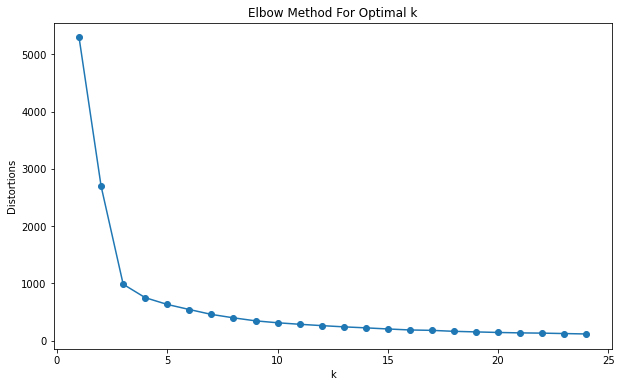

In [65]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(K, distortions, marker='o')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('Elbow Method For Optimal k')
plt.savefig('elbow.png')
plt.show()

In [ ]:
px.scatter_mapbox(data, lat="latitude", lon="longitude", color="cluster", size='review_counts', 
                  hover_data= ['name', 'latitude', 'longitude'], zoom=10, width=1200, height=800)

In [73]:
top_restaurants = data.sort_values(by=['review_counts', 'stars'], ascending=False)
top_restaurants.head(2)

,business_id,name,city,state,latitude,longitude,stars,attributes,categories,user_id,review_stars,text,review_counts,year,text_word_count,pos_neg,text_clean
195372,r_BrIgzYcwo1NAuG9dLbpg,Pai Northern Thai Kitchen,Toronto,ON,43.647866,-79.388642,4.5,"{'Ambience': ""{'romantic': False, 'intimate': ...","Restaurants, Food, Thai, Ethnic Food, Specialt...",w_yPQOQ-_eKRKZU96foIIQ,5.0,"My favorite spot for quick lunch and dinner, i...",2177,2018,93,1,favorite spot quick lunch dinner right next of...
195373,r_BrIgzYcwo1NAuG9dLbpg,Pai Northern Thai Kitchen,Toronto,ON,43.647866,-79.388642,4.5,"{'Ambience': ""{'romantic': False, 'intimate': ...","Restaurants, Food, Thai, Ethnic Food, Specialt...",GG4QPrqU7wxL8WVXuzozMg,5.0,This place is delicious with great service and...,2177,2017,67,1,place delicious great service vibe make feel l...


In [76]:
def recommend_restaurants(data, longitude, latitude):
    cluster = kmeans.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    print(cluster)

    return  data[data['cluster']==cluster].iloc[0:5][['name', 'latitude','longitude']]

In [ ]:
test_coordinates = {
    'user': [1, 2, 3], 
    'latitude' : [36.1017316, 36.0842838, 36.155011],
    'longitude' : [-115.1891691, -115.2798544, -115.082821],
}

test_df = pd.DataFrame(test_coordinates)
test_df

In [ ]:
user1 = test_df[test_df['user'] == 1]
user1

In [ ]:
fig = px.scatter_mapbox(recommend_restaurants(top_restaurants_Vancouver, user1.longitude, user1.latitude), lat="latitude", lon="longitude",  
                   zoom=10, width=1200, height=800, hover_data= ['name', 'latitude', 'longitude'])
fig.add_scattermapbox(lat=user1["latitude"], lon= user1["longitude"]).update_traces(dict(mode='markers', marker = dict(size = 15)))

In [ ]:
user2 = test_df[test_df['user'] == 2].reset_index()
fig = px.scatter_mapbox(recommend_restaurants(top_restaurants_lasVegas, user2.longitude, user2.latitude), lat="latitude", lon="longitude",  
                   zoom=10, width=1200, height=800, hover_data= ['name', 'latitude', 'longitude'])
fig.add_scattermapbox(lat=user2["latitude"], lon= user2["longitude"]).update_traces(dict(mode='markers', marker = dict(size = 15)))